In [1]:
from simMat_funcs import *

In [188]:
dataPath = '../Data/'
simMat_yr = np.load(dataPath + 'history_simMat.npy')

elemList = []
with open(f"{dataPath}/ElementList.txt",'r') as f:
    for line in f:
        elemList.append(line.strip())

elemList_AO = [] # Atomic weight ordered element list
for e in TP.keys():
    if e in elemList:
        elemList_AO.append(e)
            
min_yr = 1771
print(simMat_yr.shape)

(247, 103, 103)


# Meaning of 0s and nans

If element exists to this year, but similarity == 0, plot 0.

If element doesn't exist, then similarity == 0, but plot nan.

## Let's produce code to convert these data, into specific plots for each element.


In [184]:
def plot_SimPTBar(simMat_yr,year,element,min_yr):
    # Select simMat for this year
    arr_yr = simMat_yr[year-min_yr].copy()
    # Select a particular element
    X,Y = TP[element]

    # Generate a list of elements present at the given year
    c,elems_yr = 0,[]  # counter, element list
    for e in TP.keys():
        if e in elemList:
            # If all entries at this place are nan: they don't exist
            if (~np.isnan(arr_yr[:,c].all())): 
                c+=1
                elems_yr.append(e)

    # Select the array for the given element, for the given year
    arr_thisElem = arr_yr[:,elems_yr.index(element)]
    arr_thisElem[elems_yr.index(element)] = 0  # Remove this element's value, so it's white as well

    img = np.zeros((7,32))
    mask = img.copy()
    # Create a mask to wipe out nan entries, so they appear as white
    c = 0
    for e in elems_yr:
        x,y = TP[e]
        mask[x,y] = 1
        if ~np.isnan(arr_thisElem[c]):
            img[x,y] = arr_thisElem[c]
            c+=1

    mask[X,Y] = 0
    with np.errstate(invalid='ignore',divide='ignore'):
        img /= mask

    # Plot similarity PT for elem
    fig = plt.figure(figsize=(18,7))
    gs = fig.add_gridspec(2,2,  width_ratios=(99, 1), height_ratios=(6, 4),
                  #    left=0, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0.2)

    ax = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, :])
    cbar = fig.add_subplot(gs[0,1])

    cmap = sns.color_palette("magma", as_cmap=True)
    sns.heatmap(img,ax=ax,cbar_ax=cbar,
                vmin=0,vmax=np.nanmax(img),
                cmap=cmap)

    ax.set_title(f'Replaceability of {element} in chemical formulas, Year = {year}', fontsize=20)

    ax.axis('off')

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    #ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)

    # Plot barplot
    df = (pd.Series(arr_thisElem,index=elems_yr)
          .reset_index()
          .rename(columns={'index':'Element',
                           0:'Occurences'}))
    df = df[df.Element != element]

    df['color'] = (df['Occurences']/df['Occurences'].max()).apply(cmap)
    ax1.bar(x=range(df.shape[0]) ,
            height=df['Occurences'],
            color=df['color'],edgecolor = "k")

    ax1.set_xticks(range(df.shape[0]))
    ax1.set_xticklabels(df['Element'],fontsize=8)
    ax1.set_xlim(-1,df.shape[0])

    # Put the element's symbol at it's position
    if len(element)==1:  tab = 0.2
    else:                tab = 0.02
    ax.text(Y+tab,X+0.7,element,fontsize=17)

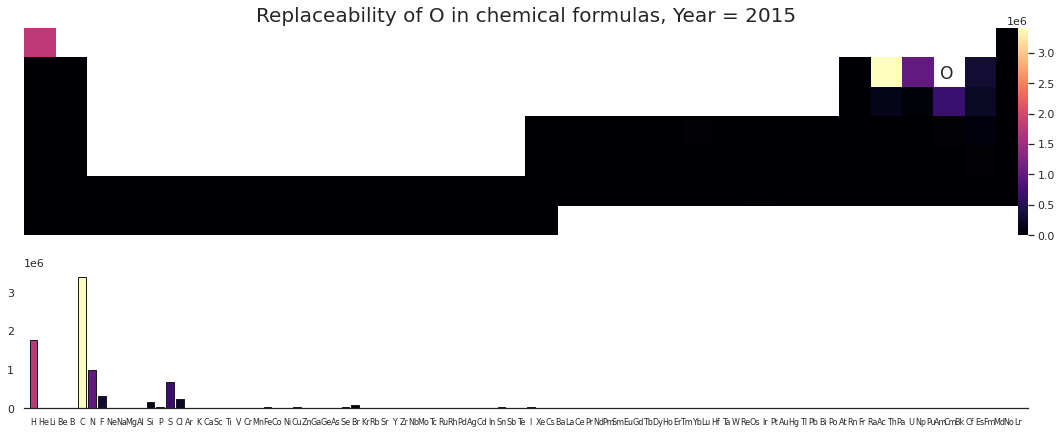

In [4]:
for y in [2015]:
    plot_SimPTBar(simMat_yr,y,'O',min_yr)

# Plot similarity matrices for a given year.

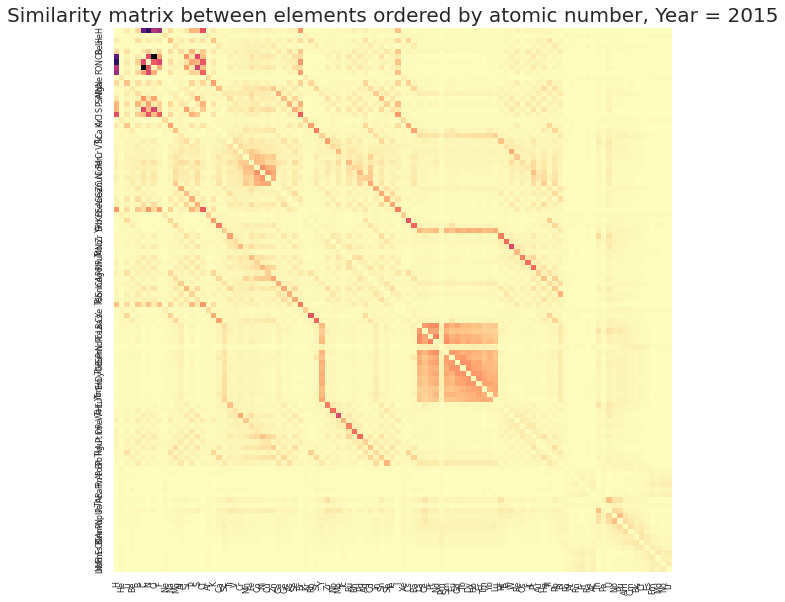

In [245]:
def plot_simMat_yr(year,min_yr=min_yr,save=False,raw=True,palette='magma_r',ordering=False,scale=15):
    """Plot similarity matrix for a given year
    year: which year to plot
    raw:  plot the raw normalized matrix (non-symmetric)
        if raw=False: plot symmetrized version
    ordering: lists position of elements ordered by atomic number. 
        e.g. [40,21,10] means H is in position 40, He in 21 and Li is 10th.
    """
    S = simMat_yr[year - min_yr].copy()
    
    # First change order, then clean empty rows + cols
    if type(ordering)!=bool: # Use new order
        indices = ['_' for i in range(103)]
        labels = indices.copy()
        for i,idx in enumerate(ordering):
            indices[idx] = i
            labels[idx] = elemList_AO[i]
        S = S[indices][:,indices]
        
    else: labels = elemList_AO
    
    # Remove non-existent elements (diag==0)
    diag = np.diag(S)
    isn = diag!=0
    S = S[isn][:,isn]
    n = isn.sum()
    diag = diag[isn]
    
    if raw:    P = (S/diag).T        
    else:
        Sum0 = S.sum(axis=0).reshape(-1,1).repeat(n,axis=1)
        Sum1 = S.sum(axis=1).reshape(1,-1).repeat(n,axis=0)
        P = np.sqrt(S**2/(Sum0*Sum1))
        
    ## Replace diagonal with 0, so that important features are evident
    inds = np.arange(0,n)
    P[inds,inds] = 0
    
    
    fig,ax = plt.subplots(figsize=(scale,scale))
    ax.set_title(f"Similarity matrix between elements ordered by atomic number, Year = {year}",
                 fontsize=20)
    sns.heatmap(P,ax=ax,cbar=False,
                cmap=sns.color_palette(palette, as_cmap=True))
    
    labl = np.array(labels)[isn]      
    tick = [i+0.5 for i in range(len(labl))]
    ax.set_xticks(tick)
    ax.set_yticks(tick)
    ax.set_xticklabels(labl,fontsize=8)
    ax.set_yticklabels(labl,fontsize=8)
    
    if save: plt.savefig(save,dpi=400,bbox_inches='tight')

plot_simMat_yr(2015,raw=False,scale=10)

Based on the work of [Glawe et.al.](https://iopscience.iop.org/article/10.1088/1367-2630/18/9/093011), we define a new matrix P, a symmetrized version of the matrices $S$ above, in which $S_{AB}$ are interpreted as the probability of replacing element A by element B while obtaining an existing compound.

Matrix elements $P_{AB}$ are defined as follows:

$$
P_{AB} = \sqrt{\frac{S_{AB}^2}{(\sum_{A'}{S_{A'B}})(\sum_{B'}{S_{AB'}})}}
$$

This quantity is calculated and plotted below.

### Here we get the same overall patterns as the reference, only that somewhat obfuscated by the similarity between H and O, C, N, not obtained there. With this, let us now try to reproduce their results.

For various reasons, the present work represents a huge step forward relative to the reference:
- As we include data from all existing compounds in Reaxys, not limited to inorganic or even solids, we use far more data for our analysis, and thus provide a much less biased picture of the results.
- We are able to perform historical analyses. In that sense, we could try to answer the question about how different formulations of 1D periodic tables evolve with an evolving chemical space.

---

The cost function we'll be using here is defined below.

$$
F = -\sum_{A,B \neq A} \frac{P_{AB}}{|i_A - i_B|}
$$

Which takes into account the distances between all pairs of elements in the given ordering $i$, and weights each contribution with the elements $P_{AB}$.

### For what follows: If we're doing historical analyses, some elements will be missing. If so, fill nans with zeros on matrix P, for code reusability (so P and orderings have all the same dimensions regardless of year).

In [205]:
def symmetrize(S):
    """Get symmetrized version (P) of matrix S"""
    diag = np.diag(S)
    n = S.shape[0]
    Sum0 = S.sum(axis=0).reshape(-1,1).repeat(n,axis=1)
    Sum1 = S.sum(axis=1).reshape(1,-1).repeat(n,axis=0)
    P = np.sqrt(S**2/(Sum0*Sum1))
    # Set diagonal elements to 0
    inds = np.arange(0,n)
    P[inds,inds] = 0
    return P

def cost(P, order):
    F = 0
    i = order.reshape(1,-1)
    diffs = np.abs(i - i.T) + np.eye(i.shape[1])
    return -np.sum(P/diffs)



# Calculate P for calculating cost function
year=2015
S = simMat_yr[year - min_yr].copy()
P = symmetrize(S)

# Set a reference ordering: atomic number
orderAO = np.arange(P.shape[0])

print(f"Cost using AN order = {cost(P, orderAO):.5f}")

Cost using AN order = -8.66470


In [206]:
# How do random configurations perform
rand_ord_cost = [cost(P, np.random.permutation(order)) for i in range(5000)]

pd.Series(rand_ord_cost).describe()

count    5000.000000
mean       -4.350578
std         0.231289
min        -5.584802
25%        -4.486770
50%        -4.325215
75%        -4.187297
max        -3.766339
dtype: float64

Here, we -sort of- reproduce the article's results. We see that random orderings have F values typically between $-4$ and $-5$, while using atomic number ordering improves this value down to $-8.66$.

--- 

Let us do some tests. 

- Calculate computational time for a single cost evaluation.
- Check how Pettifor's scale does on these data.
- Check how many possible orderings there are for 103 elements in our dataset.

In [207]:
%%timeit
# 1. Calculate computational time for a single cost evaluation.
# Generating random order and calculating cost
cost(P, np.random.permutation(order))

72.9 µs ± 4.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [208]:
# How many evaluations are reasonable?
n = 1e8
print(f"Time for {n} cost evaluations: {69.5e-6*n/3600:.5f} hours")

Time for 100000000.0 cost evaluations: 1.93056 hours


In [209]:
# 2. Check how Pettifor's scale does on these data.

pettif = ['He','Ne','Ar','Kr','Xe','Rn','Fr','Cs','Rb','K','Na','Li','Ra','Ba','Sr','Ca','Yb','Eu','Y',
          'Sc','Lu','Tm','Er','Ho','Dy','Tb','Gd','Sm','Pm','Nd','Pr','Ce','La','Lr','No','Md','Fm','Es',
          'Cf','Bk','Cm','Am','Pu','Np','U','Pa','Th','Ac','Zr','Hf','Ti','Nb','Ta','V','Mo','W','Cr',
          'Tc','Re','Mn','Fe','Os','Ru','Co','Ir','Rh','Ni','Pt','Pd','Au','Ag','Cu','Mg','Hg','Cd','Zn',
          'Be','Tl','In','Al','Ga','Pb','Sn','Ge','Si','B','Bi','Sb','As','P','Po','Te','Se','S','C','At',
          'I','Br','Cl','N','O','F','H']

# List the position of each element in Pettifor scale
order_pett = np.array([pettif.index(e) for e in TP.keys()])
# e.g. H: 102, He: 0, Li: 11, etc

print(order_pett)
print(f"\nCost = {cost(P, order_pett)}")

[102   0  11  76  85  94  99 100 101   1  10  72  79  84  89  93  98   2
   9  15  19  50  53  56  59  60  63  66  71  75  80  83  88  92  97   3
   8  14  18  48  51  54  57  62  65  68  70  74  78  82  87  91  96   4
   7  13  32  31  30  29  28  27  17  26  25  24  23  22  21  16  20  49
  52  55  58  61  64  67  69  73  77  81  86  90  95   5   6  12  47  46
  45  44  43  42  41  40  39  38  37  36  35  34  33]

Cost = -12.56132025019665


In [210]:
# See how their GA solution works

GA_ref = ['He','Ne','Ar','At','Rn','Fr','Es','Fm','Md','No','Lr','Kr','Xe','Pm','Cs','Rb','K','Na',
          'Li','Ra','Ba','Sr','Ca','Eu','Yb','Lu','Tm','Y','Er','Ho','Dy','Tb','Gd','Sm','Nd','Pr',
          'Ce','La','Ac','Am','Cm','Bk','Cf','Pu','Np','U','Th','Pa','Sc','Zr','Hf','Ti','Nb','Ta',
          'V','Cr','Mo','W','Re','Tc','Os','Ru','Ir','Rh','Pt','Pd','Au','Ag','Cu','Ni','Co','Fe',
          'Mn','Mg','Zn','Cd','Hg','Be','Al','Ga','In','Tl','Pb','Sn','Ge','Si','B','C','N','P','As',
          'Sb','Bi','Po','Te','Se','S','O','I','Br','Cl','F','H']

# List the position of each element in Pettifor scale
order_GA = np.array([GA_ref.index(e) for e in TP.keys()])
# e.g. H: 102, He: 0, Li: 11, etc

print(order_GA)
print(f"\nCost = {cost(P, order_GA)}")

[102   0  18  77  86  87  88  97 101   1  17  73  78  85  89  96 100   2
  16  22  48  51  54  55  72  71  70  69  68  74  79  84  90  95  99  11
  15  21  27  49  52  56  59  61  63  65  67  75  80  83  91  94  98  12
  14  20  37  36  35  34  13  33  23  32  31  30  29  28  26  24  25  50
  53  57  58  60  62  64  66  76  81  82  92  93   3   4   5  19  38  46
  47  45  44  43  39  40  41  42   6   7   8   9  10]

Cost = -12.63149025551466


### The genetic algorithm solution does perform better than the original Pettifor scale, although is not as dramatic a result as reported in ref.

In [211]:
# 3. Check how many possible orderings there are for 103 elements in our dataset. 
# This is clearly equal to N!
def factorial(N):
    preexp = np.sum(np.log(np.arange(1,N+1)))
    return np.exp(preexp)
factorial(101)

9.425947759838831e+159

Way too much for even aspiring to the evaluation of all possible configurations.

## Now finally: Let's implement a genetic algorithm for optimization of a Pettifor scale with our own data. :)

Ultimately, what we need to do is find an optimal permutation of the numbers in the range from 0 to $N$ ($N=103$ in 2015). With that, the outline for our GA implementation is as follows:

- Create an 'individual' class, which will contain the information about the configuration. 
    - Definition of a class also allows to pass it as an argument for a crossover function, and allows to define a mutate function within it. 


In [232]:
class Individual:
    def __init__(self,N,gen=False):
        self.N = N
        if type(gen)!=bool:            self.gen = gen
        else:              self.gen = np.random.permutation(self.N)
        self.cost = cost(P,self.gen)

    def PMX(self,parent):
        """Partially-mapped crossover (PMX)
        Assumes NParents=2
        parent is an `Individual` object containing the other parent"""
        NParents = 2
        
        offsp = -np.ones((NParents,self.N),dtype=np.short)
        cutpts = np.sort(np.random.randint(1,self.N-1,2))
        
        m0,m1 = self.gen[cutpts[0]:cutpts[1]] , parent.gen[cutpts[0]:cutpts[1]]
        # Define initial mapping
        offsp[0,cutpts[0]:cutpts[1]] = m1
        offsp[1,cutpts[0]:cutpts[1]] = m0
        
        ### Start filling
        offsp[0,:cutpts[0]] = self.gen[:cutpts[0]]
        offsp[1,:cutpts[0]] = parent.gen[:cutpts[0]]
        offsp[0,cutpts[1]:] = self.gen[cutpts[1]:]
        offsp[1,cutpts[1]:] = parent.gen[cutpts[1]:]
        
        map0 = dict(zip(m1,m0))
        map1 = dict(zip(m0,m1))
        
        for i in range(cutpts[0]):
            while offsp[0,i] in m1:
                offsp[0,i] = map0[offsp[0,i]]
            while offsp[1,i] in m0:
                offsp[1,i] = map1[offsp[1,i]]
              
        for i in range(cutpts[1],self.N):
            while offsp[0,i] in m1:
                offsp[0,i] = map0[offsp[0,i]]
            while offsp[1,i] in m0:
                offsp[1,i] = map1[offsp[1,i]]
                
        return [Individual(self.N,gen=offsp[i]) for i in range(2)]
    
    def mutate(self):
        """Move a random slice of the genes to a random place"""
        
        indiv = self.gen
        cutpts = np.sort(np.random.randint(0,self.N,2))
        Slice = indiv[cutpts[0]:cutpts[1]].copy()
        
        Left = np.concatenate([indiv[:cutpts[0]],indiv[cutpts[1]:]])              
        move_to = np.random.randint(0,Left.shape[0])
        
        self.gen = np.concatenate([Left[:move_to],Slice,Left[move_to:]]) 
    
class Population:
    def __init__(self,size,N,NParents=2,T=0.7,gens = False,Indivs=False):
        self.size = size  # Number of individuals
        self.N = N        # Number of elements in dataset
        self.NParents = NParents # Number of parents for a single breed
        self.T = T        # Temperature for probabilities.
        
        if not Indivs:
            if gens:        self.indivs = [Individual(N,gen=gens[i]) for i in range(size)]
            else:           self.indivs = [Individual(N) for i in range(size)]
        else:               self.indivs = Indivs
            
        self.costs = [i.cost for i in self.indivs]
        
        # Probabilites of breeding for each individual
        # Use Boltzmann's distrib. with T. A lower T means an more uneven distribution (~ 0.x)
        self.probs = np.array([np.exp(-cost/T) for cost in self.costs])
        Z = np.sum(self.probs)
        self.probs = self.probs/Z
        
        ### Store best global configuration
        self.bestCost = 0
        self.bestIndiv = False
        
    def minCost(self):
        return np.min(self.costs)
    def meanCost(self):
        return np.mean(self.costs)
    def getBestIndiv(self):
        return self.indivs[np.argmin(self.costs)]
    
    def partnerUp(self):
        """Create a group of individuals for crossover"""
        parents = []
        idx = np.random.choice(np.arange(self.size),size=self.NParents,replace=False,p=self.probs)
        for i in idx:
            parents.append(self.indivs[i])
        return parents
    
    def newBreed(self,crossover,mutRate):
        newIndivs = []
        for i in range(self.size//2):
            parents = self.partnerUp()  # Select couples
            
            # Do crossover on these parents
            if crossover == 'PMX':        indivs_i = parents[0].PMX(parents[1])
    
            # Mutations
            for i in range(self.NParents):
                # Mutate each child with probability mutRate
                if np.random.random() < mutRate:    indivs_i[i].mutate()
                
            newIndivs = newIndivs + indivs_i
        return newIndivs
            
    def evolve(self,NGeners,crossover='PMX',mutRate=0.1):
        Mins,Means = [], []
        for i in range(NGeners):
            self = Population(self.size,self.N,T=self.T,
                              Indivs=self.newBreed(crossover,mutRate))
            
            minc,meanc = self.minCost(), self.meanCost()
            if minc < self.bestCost:
                self.bestCost = minc
                self.bestIndiv = self.getBestIndiv()
                
            if i%10==0:
                Mins.append(minc)
                Means.append(meanc)
                print(f"Iter No. {i}, Mean = {meanc:.3f}, Min = {minc:.3f}",end='\r')
        plt.plot(Mins)
        plt.plot(Means)
        return self

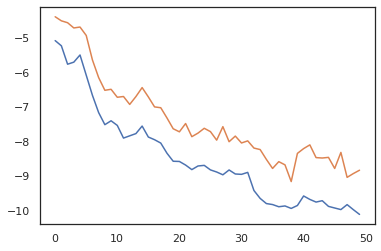

In [242]:
T , popSize = 0.9,100

breedx = Population(popSize,103,T=T)
breedx = breedx.evolve(500,mutRate=0.2)

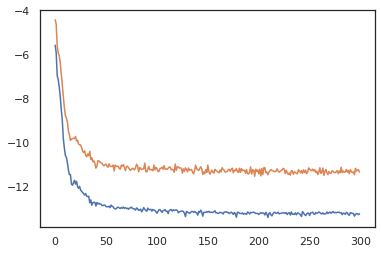

In [87]:
T , popSize = 0.7,2000

breed = Population(popSize,103,T=T)
breed = breed.evolve(3000,mutRate=0.5)

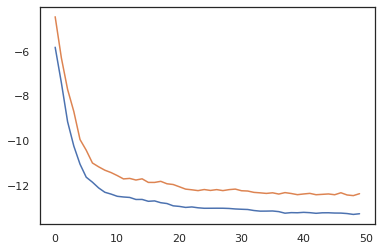

In [243]:
T , popSize = 0.4,5000

breed5k = Population(popSize,103,T=T).evolve(500,mutRate=0.1)

In [252]:



newOrder__ = ['_' for i in range(103)]
#solut_idx = breed.indivs[np.argmin(breed.costs)].gen

for i,idx in enumerate(breed5k.bestIndiv.gen):
    newOrder__[idx] = elemList_AO[i]
    
newOrder__

['Cr',
 'W',
 'Mo',
 'Ir',
 'Rh',
 'As',
 'I',
 'B',
 'P',
 'Br',
 'Cl',
 'F',
 'H',
 'N',
 'O',
 'C',
 'S',
 'Si',
 'Se',
 'Ge',
 'Sn',
 'Ti',
 'Nb',
 'Ta',
 'V',
 'Te',
 'Re',
 'Tc',
 'Pa',
 'Fr',
 'Kr',
 'Ar',
 'Ne',
 'Xe',
 'Ac',
 'He',
 'Au',
 'Ag',
 'Ni',
 'Cu',
 'Mn',
 'Co',
 'Zn',
 'Cd',
 'Pb',
 'Sr',
 'Ca',
 'Ba',
 'Mg',
 'Hg',
 'Hf',
 'Zr',
 'Th',
 'U',
 'Fe',
 'Os',
 'Ru',
 'Be',
 'Rn',
 'Pm',
 'Yb',
 'Sc',
 'Lu',
 'Tm',
 'Ho',
 'Er',
 'Y',
 'Dy',
 'Sm',
 'Tb',
 'Gd',
 'Eu',
 'Nd',
 'Pr',
 'La',
 'Ce',
 'Tl',
 'In',
 'Ga',
 'Al',
 'Li',
 'Cs',
 'Rb',
 'K',
 'Na',
 'Po',
 'Np',
 'Pu',
 'Am',
 'Cf',
 'Cm',
 'Fm',
 'Es',
 'Bk',
 'Sb',
 'Bi',
 'Lr',
 'Pd',
 'Pt',
 'No',
 'At',
 'Md',
 'Ra']

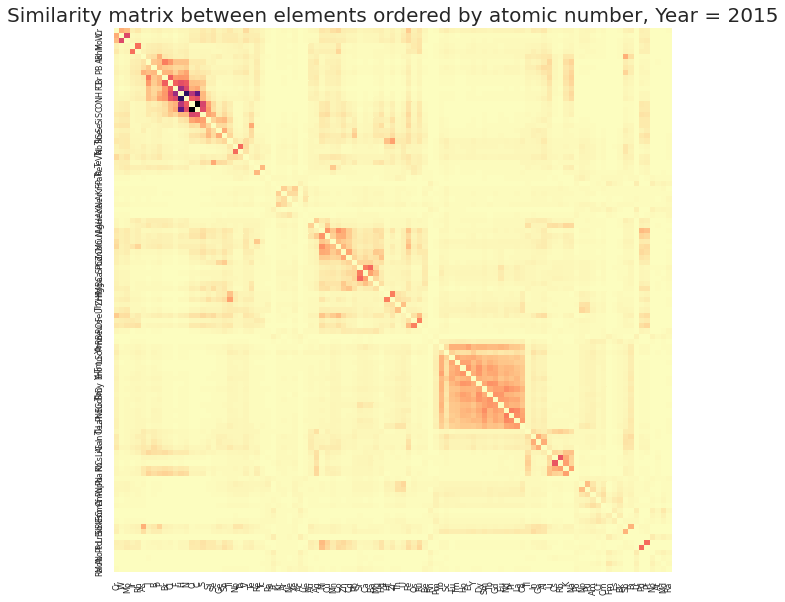

In [246]:
plot_simMat_yr(2015,raw=False,scale=10,ordering=breed5k.bestIndiv.gen)

In [95]:
breed.minCost() - ( -12.63149)

-0.7538772309804163

### Benchmarks:

Pettifor: -12.5613202

Glawe GA: -12.6314902

### We have a working implementation of a genetic algorithm, and the results so far are superior to those of Glawe (with our dataset).

### Let's now try to compare different candidate configurations. As opposed to the reference, where the authors visually inspected the orderings, here we'll use more formal quantities that allow to rate similarities between scales, and don't depend on fixed extremes (ref. used Kr and H to be fixed to the extremes of the orderings).

The idea I have is to compare the content of N-grams. For instance, if an ordering $O_1$ has the ordered pair (Na,K) at position $N_1$, and ordering $O_2$ has the ordered pair (K,Na) at position $N_2$, $N_1 \neq N_2$, then both orderings have a strong sense of similarity between Na and K, regardless of localization within the particular ordering ($N_i$), or of the particular ordering of the given ordered pair. As such, similarity between $O_1$ and $O_2$ should increase.

The pairs above are examples of 2-grams, but we could also take the same approach for 3-grams, and so on.

In [312]:
def genToElem(gen):
    order = ['_' for i in range(103)]
    for i,idx in enumerate(gen):
        order[idx] = elemList_AO[i]
    return order

def getNGrams(seq,N):
    """Returns a list of NGrams (sets) in seq"""
    ngrams = []
    for i in range(len(seq)-N):
        ngrams.append(set(seq[i:i+N]))
    return ngrams

def compareNGrams(seq1,seq2,N):
    """Compare NGrams of seq1 and seq2
    Calculate: Number of NGrams of seq1 that are also in seq2, divided by number of NGrams in seq1
    """
    ng1 = getNGrams(seq1,N)
    ng2 = getNGrams(seq2,N)
    
    NNgrams = len(ng1)*N
    total = 0
    for i in ng1:
        for j in ng2:
            #if len(i.intersection(j)) == N:
            #    total += 1
            #    break
            if len(i.intersection(j)) >1:
                total += len(i.intersection(j))
    return total/NNgrams

In [314]:
s1 = genToElem(order_GA)#breed5k.bestIndiv.gen)
s2 = genToElem(order_pett)#solut_idx)

compareNGrams(s1,s2,3)

1.6733333333333333

In [ ]:
np.random.permutation(elemList_AO)

### 0.356 # is max 3 grams

In [ ]:

m = 0
for i in range(5000):
    s1 = genToElem(breed5k.indivs[i].gen)
    s2 = genToElem(solut_idx)

    a = compareNGrams(s1,s2,4)
    if a > m:
        m = a
m

---

# Calculate mean(HND) from SMs.

### To calculate a mean, we sum, and then divide by the number of elements.

# sum(HND):

Let's first calculate HND for a single element, H.

Each other element x contributes a given distance, a specific number of times. This distance D(H,X) is the difference in PT groups, which has to be counted N(H,X) times, N(H,X) being the number of times both H and X appear in the same table.

Thus, each element contributes a total N(H,X)*D(H,X) to the sum, which results in the sum:

<br>
<font color='red' >
    $$
    sum(HND(H)) = N(H,H)*D(H,H) + N(H,He)*D(H,He) + N(H,Li)*D(H,Li) + ...
    $$
</font>

Where a term for the pair (H,H) was added as $D(H,H) = 0$, by definition.

<br>
<font color='red' >
    $$
    \begin{align*}
    sum(HND(H)) &= \sum_{X} N(H,X)*D(H,X)\\
           &= \sum_{X} N(H,X)*D(X,H)
    \end{align*}
    $$
</font>

Due to the fact that both matrices are symetric.

---

#### Definitions:

1. Matrix D, where $D_{ij} = D(i,j)$ for elements i and j. 

2. Matrix N. $N_{ij} = N(i,j)$ for elements i and j. 

The above equation is realized as an inner product between the rows of D and N, correspondent to element H.

And, extending the argument to the complete set of elements, we compute the diagonal of the matrix product between N and D:

<br>
<font color='red' >
$$
sum(HND) = Diag(N*D)
$$
</font>

Which is a vector containing sum(HND(X)) for each element X.

# mean(HND):

Renamed as mHND for ease of write and read.

For that, we need to rescale Diag(N*D) using the total number of neighbors of each element.

Number of neighbors of H is equal to the sum of N(H), minus N(H,H); which generalizes as sum(N,axis=0) - Diag(N)

We end up with the following:

<br>
<font color='red' >
$$
mHND = \frac{Diag(N*D)}{sum(N,axis=0) - Diag(N) }
$$
</font>

# Calculation of D.

A vector `g` can be written, such that g(X) = group(X), representing the horizontal position of element X within a given PT (group). 

With this, we could repeat the vector to build a square matrix G, which then can be used to calculate D as follows:

<br>
<font color='red' >
$$
D = |G - G^T|
$$
</font>

Numpy broadcasting rules allow to do this without the repeating step being explicitly made. 

As such, we'd rather calculate 

<font color='red' >
$$
D = |g - g^T|
$$
</font>

The equation is then written in terms of the most fundamental variable here (g), as follows:

<br>
<font color='#8120b1' size=5 >
$$
mHND = \frac{Diag(N*|g - g^T|)}{sum(N,axis=0) - Diag(N) }
$$
</font>

<br>
<font color='#3b8167' size=5 >
Note that N is already calculated and varies yearly, while D is a constant for a given PT, so this makes computation of mHND extremely efficient.
</font>


## Note: If we're looking forward to optimize mHND, that would be only an optimization with respect to element positions in PT, whose information is all encoded in matrix D.
<br>
<font color='green' size=5>
    Which might indicate that this problem can be solved mathematically! I don't yet know how though :c
</font>

<br>
<br>
<font color='red' size=4>
    Important: The original implementation of mHND didn't consider the term -Diag(N), so the results are reproduced if the following equation is used instead of the above.
</font>


$$
mHND = \frac{Diag(N*|g - g^T|)}{sum(N,axis=0)}
$$

---

### Computational note:

Further efficiency can be achieved if the composition of operations `Diag(N*D)` is replaced in numpy with the single operation `np.einsum('ij,ji->i', N, D)`, which directly computes only the diagonal of the matrix product, instead of computing every element of such product, and then extracting the diagonal.

---

### In strict mathemathical terms, mHND for an element is calculated with the following expression:

$$
mHND_{i} = \frac{\sum_k N_{ik} | g_i - g_k |}{\sum_k N_{ik} - N_{ii}}
$$

### If sum of this quantity is used to score a PT, then we get the following:

$$
S = \sum_i \frac{\sum_k N_{ik} | g_i - g_k |}{\sum_k N_{ik} - N_{ii}}
$$

# Which is the quantity to be optimized


---


### Calculating gradients of S with respect to $g_i$ is now trivial.

$$
\frac{\partial S}{\partial g_j} = \sum_i \frac{ sign( g_i - g_j ) N_{ij} }{\sum_k N_{ik} - N_{ii}}
\\
As \\
\frac{\partial g_{k \neq j}}{\partial g_j} = 0
$$



In [5]:
# We regard this array as fixed, so don't count indexing in computation
N = simMat_yr[2015-min_yr]

$$
S = \sum_i \frac{\sum_k N_{ik} | g_i - g_k |}{\sum_k N_{ik} - N_{ii}}
$$

In [6]:
%%timeit
g = np.array([TP[e][1] for e in elemList_AO]).reshape(1,-1)
D = np.abs(g - g.T)
hnd = np.einsum('ij,ji->i', N, D)/(N.sum(axis=0) - np.diag(N))

78.8 µs ± 402 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [6]:
g = np.array([TP[e][1] for e in elemList_AO]).reshape(1,-1)
D = np.abs(g - g.T)
hnd = np.einsum('ij,ji->i', N, D)/(N.sum(axis=0) - np.diag(N))

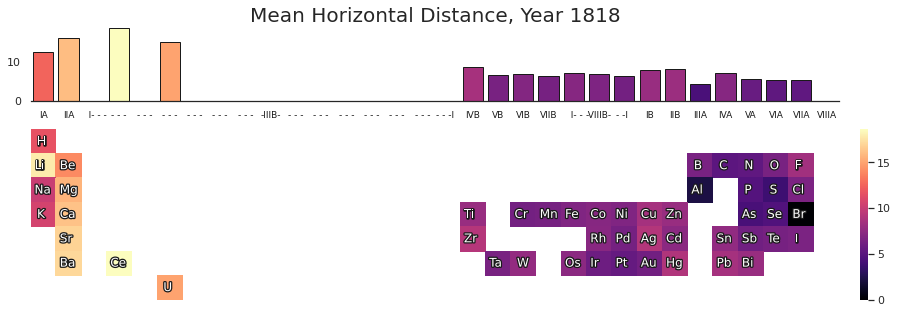

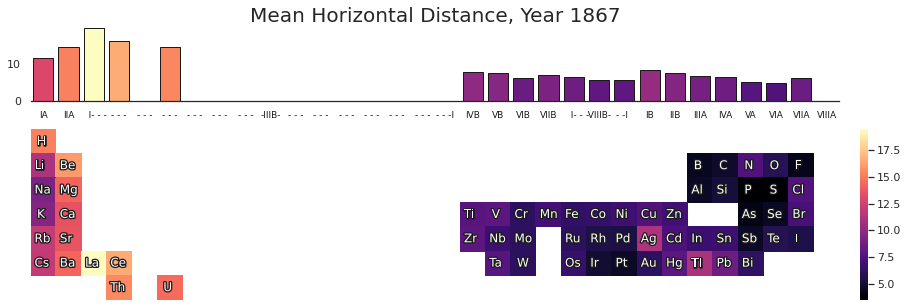

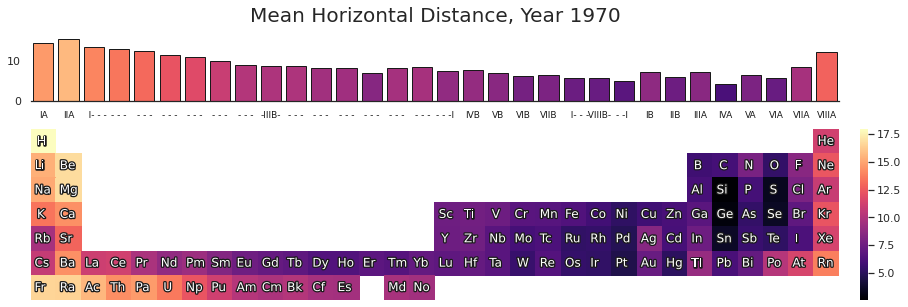

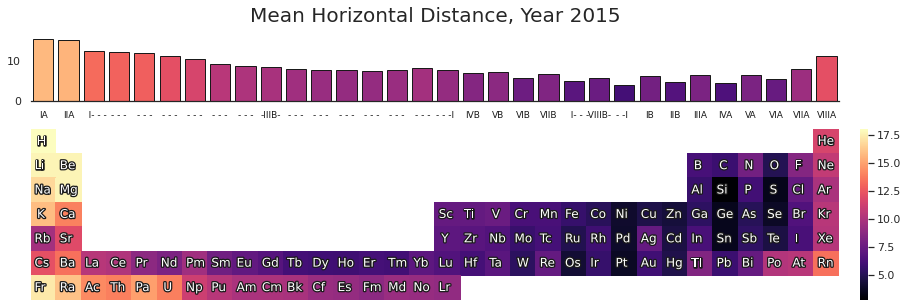

In [8]:
from HND_funcs import *

grid_kws = {'width_ratios': (0.99, 0.01), 
            'height_ratios':(0.3,0.7),
            'wspace': 0.05,'hspace':0.23}

dates = [1818,1867,1970,2015]

for d in dates:
    N = simMat_yr[d-min_yr]
    with np.errstate(invalid='ignore',divide='ignore'):
        hnd = np.diag(N@D)/(N.sum(axis=0))# - np.diag(N))
    
    dt = np.zeros((7,32))*np.nan
    for i,e in enumerate(elemList_AO):
        y,x = TP[e]
        dt[y,x] = hnd[i]

    min_scale = np.nanmin(dt)
    max_scale = np.nanmax(dt)

    fig, ax = plt.subplots(2, 2, gridspec_kw = grid_kws, figsize = (15, 5))

    makeTPPlot(dt,title=f"Mean Horizontal Distance, Year {d}",PT=TP,fs=10,ax=ax,
               min_scale=min_scale,max_scale=max_scale)
    plt.show()

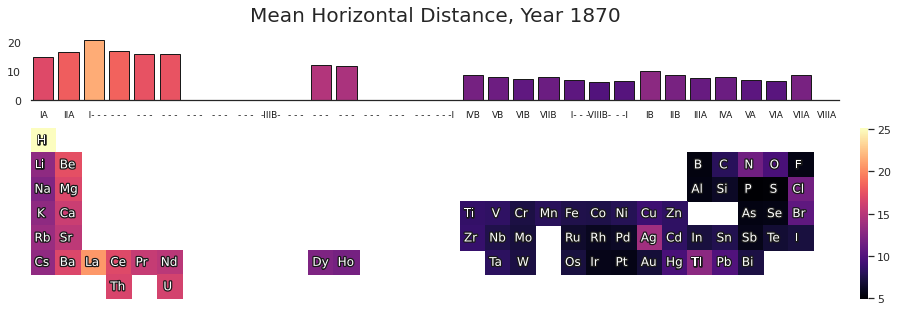

646.7829047956154


In [17]:
d = 1870

N = simMat_yr[d-min_yr]
with np.errstate(invalid='ignore',divide='ignore'):
    hnd = np.diag(N@D)/(N.sum(axis=0) - np.diag(N))

dt = np.zeros((7,32))*np.nan
for i,e in enumerate(elemList_AO):
    y,x = TP[e]
    dt[y,x] = hnd[i]

min_scale = np.nanmin(dt)
max_scale = np.nanmax(dt)

fig, ax = plt.subplots(2, 2, gridspec_kw = grid_kws, figsize = (15, 5))

makeTPPlot(dt,title=f"Mean Horizontal Distance, Year {d}",PT=TP,fs=10,ax=ax,
           min_scale=min_scale,max_scale=max_scale)#,save='/home/andres/Schreibtisch/GR/work/inf/mHND_1868.png')
plt.show()

print(np.nansum(hnd))